<h1> City Optimization in NYC

During my research, I found inspiration in digital twin cities. Digital twins allow urban planners to simulate environmental and development projects using various sensors. Simultaneously, this technology allows city officials to virtually monitor city performance in real time after cities are built and make more informed decisions in the future regarding projects.


Digital twin technology has been used in New York City by Columbia researchers to optimize traffic management systems in West Harlem. Sensors from roadside infrastructure and local vehicles provide data for machine learning models to simulate traffic flows, which have the potential to create smarter driving assistant applications in the future.

I focused on energy efficiency for the purposes of this project. Engineering buildings so they use less energy in their daily operations is one of the most cost-effective ways to fight the effects of climate change while reducing costs for both consumers and businesses. I aggregated energy efficiency data for buildings across each borough of New York City to pinpoint the least energy efficient borough, and create visualizations to depict a picture of areas of the city and within the borough where significant improvements could be made.

I then both visualized and analyzed possible correlations between energy efficiency, proportion of older housing, and air pollutant levels across boroughs using the relevant data sets.

<h2> Part One: Setup

<h3> Import modules

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import geopandas
import contextily as ctx
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

<h3> Read in and preview data

In [4]:
nyc_property_data = pd.read_csv('data/energy.csv', low_memory=False)

In [5]:
nyc_old_homes_data = pd.read_csv('data/old_homes.csv')

In [6]:
nyc_black_carbon_data = pd.read_csv('data/black_carbon.csv')

In [7]:
nyc_property_data.shape

(29842, 248)

In [8]:
nyc_old_homes_data.shape

(3895, 7)

In [9]:
nyc_black_carbon_data.shape

(5347, 8)

In [10]:
nyc_property_data.head(1)

,Property Id,Property Name,Parent Property Id,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postal Code,...,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Generation Date,Submission Date,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,21205224,Astoria Blvd Property,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/21,4006520042,4538607,36-16 Astoria Blvd.,Long Island City,11103,...,0,0,9/26/22 0:00,9/26/22 0:00,40.769272,-73.913633,401.0,22.0,6502.0,Astoria


In [11]:
nyc_old_homes_data.head(1)

,TimePeriod,GeoType,GeoID,GeoRank,Geography,Number,Percent
0,2017-21,NTA2020,50101,9,Mott Haven-Port Morris,"6,228",29.6


In [12]:
nyc_black_carbon_data.head(1)

,TimePeriod,GeoType,GeoID,GeoRank,Geography,10th percentile absorbance units,90th percentile absorbance units,Mean absorbance units
0,Annual Average 2021,CD,101,6,Financial District (CD1),0.8,0.9,0.8


<h3> Clean property data

In [13]:
#select necessary columns

property_data = nyc_property_data[['Property Id', 'Parent Property Id', 'NYC Borough, Block and Lot (BBL)','Primary Property Type - Portfolio Manager-Calculated', 'Construction Status', 'ENERGY STAR Score', 'Latitude', 'Longitude']]

In [14]:
#remove test properties used for training or testing new features in Portfolio Manager

property_data = property_data[property_data['Construction Status'] != 'Test']

In [15]:
#drop rows if missing property ids, BBL identifiers, and energy star scores using regex

property_data = property_data.replace({'ENERGY STAR Score': r'Not Available'}, {'ENERGY STAR Score': None}, regex=True)
property_data = property_data.replace({'Parent Property Id': r'Not Applicable: Standalone Property'}, {'Parent Property Id': None}, regex=True)
property_data = property_data.dropna(subset=['Property Id', 'NYC Borough, Block and Lot (BBL)', 'ENERGY STAR Score'])

In [16]:
#identify rows that are child properties

def select_child_properties(row):
    row['Child Property'] = False
    if not pd.isnull(row['Parent Property Id']) and not pd.isnull(row['Property Id']):
        if not str(row['Parent Property Id']) == None:
            if str(row['Parent Property Id']) != str(row['Property Id']):
                row['Child Property'] = True  
    return row

property_data = property_data.apply(select_child_properties, axis=1)

#drop child properties to use only parent and independent properties for analysis

properties = property_data[property_data['Child Property'] == False]

In [17]:
#drop rows if duplicate property ids

properties = properties.drop_duplicates(subset='Property Id')

In [18]:
#check to ensure there is a unique property id for each row

properties['Property Id'].value_counts()

Property Id
21205224    1
16145600    1
4413786     1
21106892    1
21057361    1
           ..
1634741     1
1634739     1
1634737     1
1634735     1
6317603     1
Name: count, Length: 21613, dtype: int64

In [19]:
#rename columns for simplicity

properties = properties.rename(columns = {'Address 1':'Address', 'NYC Borough, Block and Lot (BBL)':'Borough, Block, Lot', 'Primary Property Type - Portfolio Manager-Calculated':'Primary Property Type', 'Property GFA - Calculated (Buildings) (ft²)': 'Property GFA (ft²)'})

In [20]:
#cast BBL identifier as string for regex 

properties['Borough, Block, Lot']= properties['Borough, Block, Lot'].astype(str)

In [21]:
#get borough for each property from BBL identifier

def get_borough_number(row):
    borough_number = re.match(r'^(\d)', row['Borough, Block, Lot'])
    if borough_number:
        return borough_number.groups(1)[0]
    else:
        return None

properties['Borough Number'] = properties.apply(get_borough_number, axis=1)
properties['Borough'] = properties['Borough Number'].map({'1':'Manhattan','2':'Bronx','3':'Brooklyn','4':'Queens','5':'Staten Island'})

In [22]:
#cast energy star score as integers

properties['ENERGY STAR Score']= properties['ENERGY STAR Score'].astype(int)

In [23]:
#drop unneeded columns

properties.drop(columns=['Child Property','Borough Number', 'Construction Status'], inplace=True)

In [24]:
properties.head(1)

,Property Id,Parent Property Id,"Borough, Block, Lot",Primary Property Type,ENERGY STAR Score,Latitude,Longitude,Borough
0,21205224,None,4006520042,Multifamily Housing,71,40.769272,-73.913633,Queens


<h3> Clean old homes data

In [25]:
#limit data to same time frame as property data, separated geographically by borough

nyc_old_homes_data['TimePeriod']= nyc_old_homes_data['TimePeriod'].astype(str)
old_homes_data = nyc_old_homes_data[nyc_old_homes_data['TimePeriod'] == '2017-21']
old_homes = old_homes_data[old_homes_data['GeoType'] == 'Borough']
old_homes = old_homes[['Geography', 'Percent']]
old_homes = old_homes.rename(columns={'Geography':'Borough','Percent': '% of Homes Built Before 1950'})
old_homes

,Borough,% of Homes Built Before 1950
298,Bronx,47.1
299,Brooklyn,58.3
300,Manhattan,49.4
301,Queens,45.8
302,Staten Island,21.9


<h3> Clean black carbon data

In [26]:
#limit data to same time frame as property data, separated geographically by borough

nyc_black_carbon_data['TimePeriod']= nyc_black_carbon_data['TimePeriod'].astype(str)
black_carbon_data = nyc_black_carbon_data[nyc_black_carbon_data['TimePeriod'] == 'Annual Average 2021']
black_carbon = black_carbon_data[black_carbon_data['GeoType'] == 'Borough']
black_carbon = black_carbon[['Geography', 'Mean absorbance units']]
black_carbon = black_carbon.rename(columns={'Geography':'Borough','Mean absorbance units': 'Mean Black Carbon Absorbance Units'})
black_carbon

,Borough,Mean Black Carbon Absorbance Units
135,Bronx,0.7
136,Brooklyn,0.6
137,Manhattan,0.8
138,Queens,0.6
139,Staten Island,0.5


<h2> Part Two: Property Calculations

<h3> Calculate average energy efficiency per property by borough

ENERGY STAR Scores compare a property's energy efficiency to similar properties nationwide, taking size, location, and operating parameters of each property into account. The national median score is 50; thus, scores below 50 denote below average efficiencies and scores above 50 denote above average efficiencies.

In [27]:
borough_avg_energy_efficiency = properties.groupby('Borough')['ENERGY STAR Score'].mean().sort_values()
borough_avg_energy_efficiency

Borough
Bronx            54.826838
Brooklyn         60.115627
Queens           60.180249
Manhattan        60.595731
Staten Island    61.711974
Name: ENERGY STAR Score, dtype: float64

<h3> Calculate average energy efficiency per property by property type

In [28]:
property_type_avg_energy_efficiency = properties.groupby('Primary Property Type')['ENERGY STAR Score'].mean().sort_values()
property_type_avg_energy_efficiency

Primary Property Type
Wholesale Club/Supercenter                40.500000
Wastewater Treatment Plant                47.857143
Worship Facility                          48.763158
Senior Living Community                   49.154472
Distribution Center                       49.528571
Supermarket/Grocery Store                 51.120482
Medical Office                            52.905882
Refrigerated Warehouse                    53.888889
Hotel                                     54.270833
Non-Refrigerated Warehouse                54.300546
Mixed Use Property                        54.318182
Multifamily Housing                       57.984757
Retail Store                              58.434555
K-12 School                               62.965668
Financial Office                          68.760000
Bank Branch                               69.625000
Office                                    70.536336
Courthouse                                73.235294
Residence Hall/Dormitory                  

<h2> Part Three: Merging

In [29]:
#convert to dataframe (can only run once)

borough_avg_energy_efficiency = borough_avg_energy_efficiency.to_frame()

In [30]:
#rename columns

borough_avg_energy_efficiency = borough_avg_energy_efficiency.rename(columns = {'ENERGY STAR Score': 'Average ENERGY STAR Score'})
borough_avg_energy_efficiency

,Average ENERGY STAR Score
Borough,
Bronx,54.826838
Brooklyn,60.115627
Queens,60.180249
Manhattan,60.595731
Staten Island,61.711974


In [31]:
#merge average energy efficiency and % of old homes together for each borough

properties_and_old_homes = borough_avg_energy_efficiency.merge(old_homes, how='inner', left_index=True, right_on='Borough')
properties_and_old_homes = properties_and_old_homes.reindex(['Borough', 'Average ENERGY STAR Score', '% of Homes Built Before 1950'], axis=1)
properties_and_old_homes

,Borough,Average ENERGY STAR Score,% of Homes Built Before 1950
298,Bronx,54.826838,47.1
299,Brooklyn,60.115627,58.3
301,Queens,60.180249,45.8
300,Manhattan,60.595731,49.4
302,Staten Island,61.711974,21.9


In [32]:
#merge average energy efficiency and average black carbon absorbance units together for each borough

properties_and_black_carbon = borough_avg_energy_efficiency.merge(black_carbon, how='inner', left_index=True, right_on='Borough')
properties_and_black_carbon = properties_and_black_carbon.reindex(['Borough', 'Average ENERGY STAR Score', 'Mean Black Carbon Absorbance Units'], axis=1)
properties_and_black_carbon

,Borough,Average ENERGY STAR Score,Mean Black Carbon Absorbance Units
135,Bronx,54.826838,0.7
136,Brooklyn,60.115627,0.6
138,Queens,60.180249,0.6
137,Manhattan,60.595731,0.8
139,Staten Island,61.711974,0.5


<h2> Part Four: Visualizations

<h3> Visualize energy efficiencies per property type

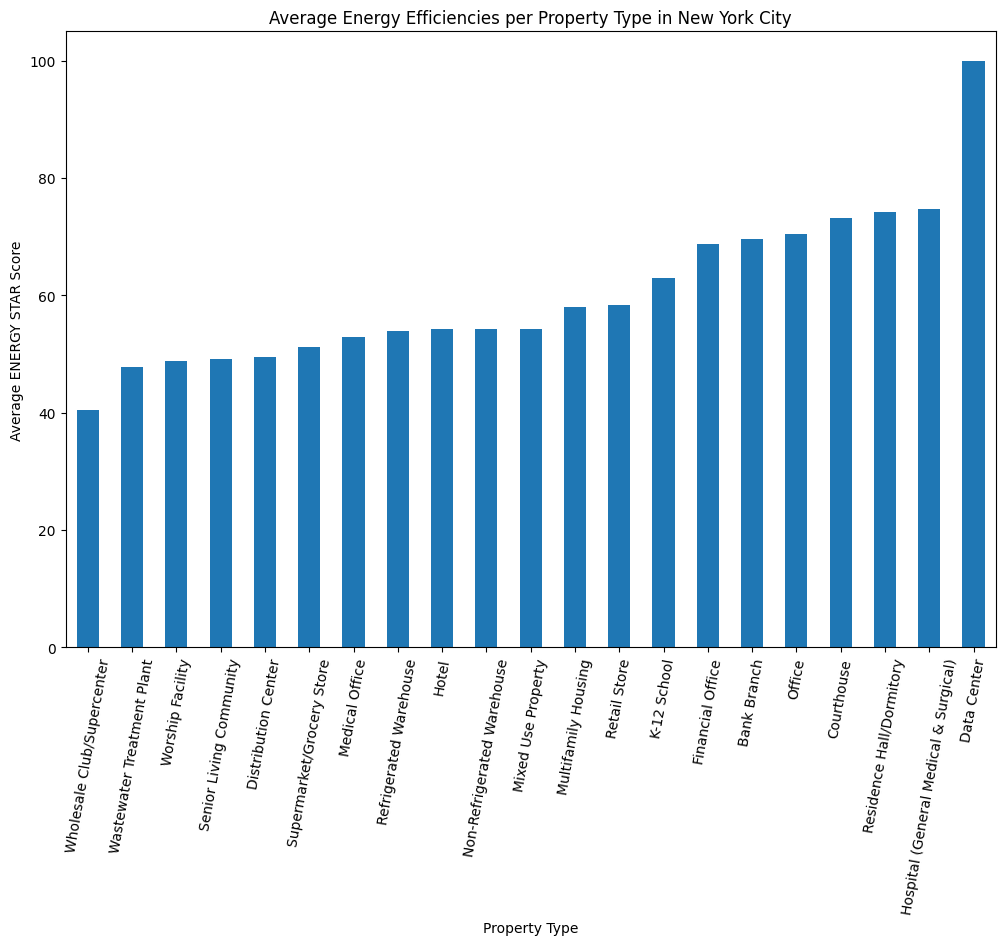

In [33]:
#set up bar plot

plt.figure(figsize=(12, 8))
property_type_avg_energy_efficiency.plot.bar(title='Average Energy Efficiencies per Property Type in New York City', xlabel='Property Type', ylabel='Average ENERGY STAR Score')
plt.xticks(rotation=80)
plt.show()

<h3> Visualize energy efficiency across New York City

/Users/iris/Desktop/SI 330/nyc_energy_efficiency/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


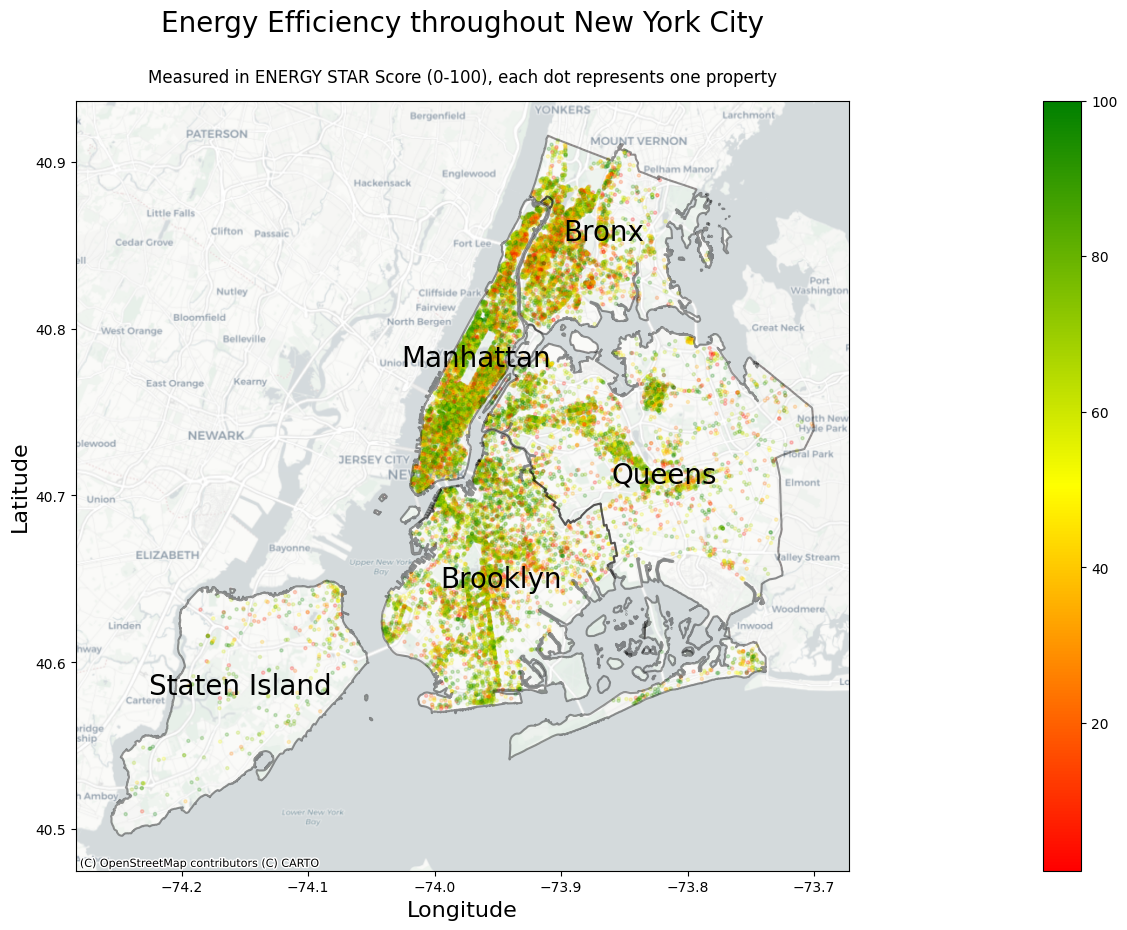

In [34]:
#set up geospatial choropleth color coding properties in new york city by energy efficiency

properties_map = geopandas.GeoDataFrame(properties, geometry=geopandas.points_from_xy(properties.Longitude, properties.Latitude), crs="EPSG:4326")
properties_map = properties_map.dropna(subset=['Latitude', 'Longitude'])

gdf = geopandas.read_file('data/nyc.shp' ) 
gdflat = gdf.to_crs({'init': 'epsg:4326'}) 

ax = gdflat.boundary.plot(figsize=(50, 10), alpha=0.4, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

#set custom colors to green to yellow to red

colors = [(1, 0, 0), (1, 1, 0), (0, 0.5, 0)]
custom = LinearSegmentedColormap.from_list('custom_colormap', colors)

ax.set_title('Energy Efficiency throughout New York City', fontsize=20, pad=50)
ax.set_xlabel('Longitude', fontsize=16) 
ax.set_ylabel('Latitude', fontsize=16) 

plt.text(0.5, 1.03, 'Measured in ENERGY STAR Score (0-100), each dot represents one property', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

properties_map.plot(column='ENERGY STAR Score', cmap=custom, markersize=5, alpha=0.2, legend=True, ax=ax)

#add labels to boroughs

for idx, row in gdflat.iterrows():
    ax.annotate(text=row['boro_name'], xy=row.geometry.centroid.coords[0], ha='center', fontsize=20)
    
plt.show()

<h3> Visualize energy efficiency across borough with lowest average energy efficiency

In [35]:
#identify borough with the lowest average energy efficiency

lowest_scores = str(borough_avg_energy_efficiency.idxmin()[0])
borough = properties[properties['Borough'] == lowest_scores]

/var/folders/1x/s2zxj99s5sd3b95t9vtqv90r0000gn/T/ipykernel_94077/3601079025.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lowest_scores = str(borough_avg_energy_efficiency.idxmin()[0])


/Users/iris/Desktop/SI 330/nyc_energy_efficiency/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


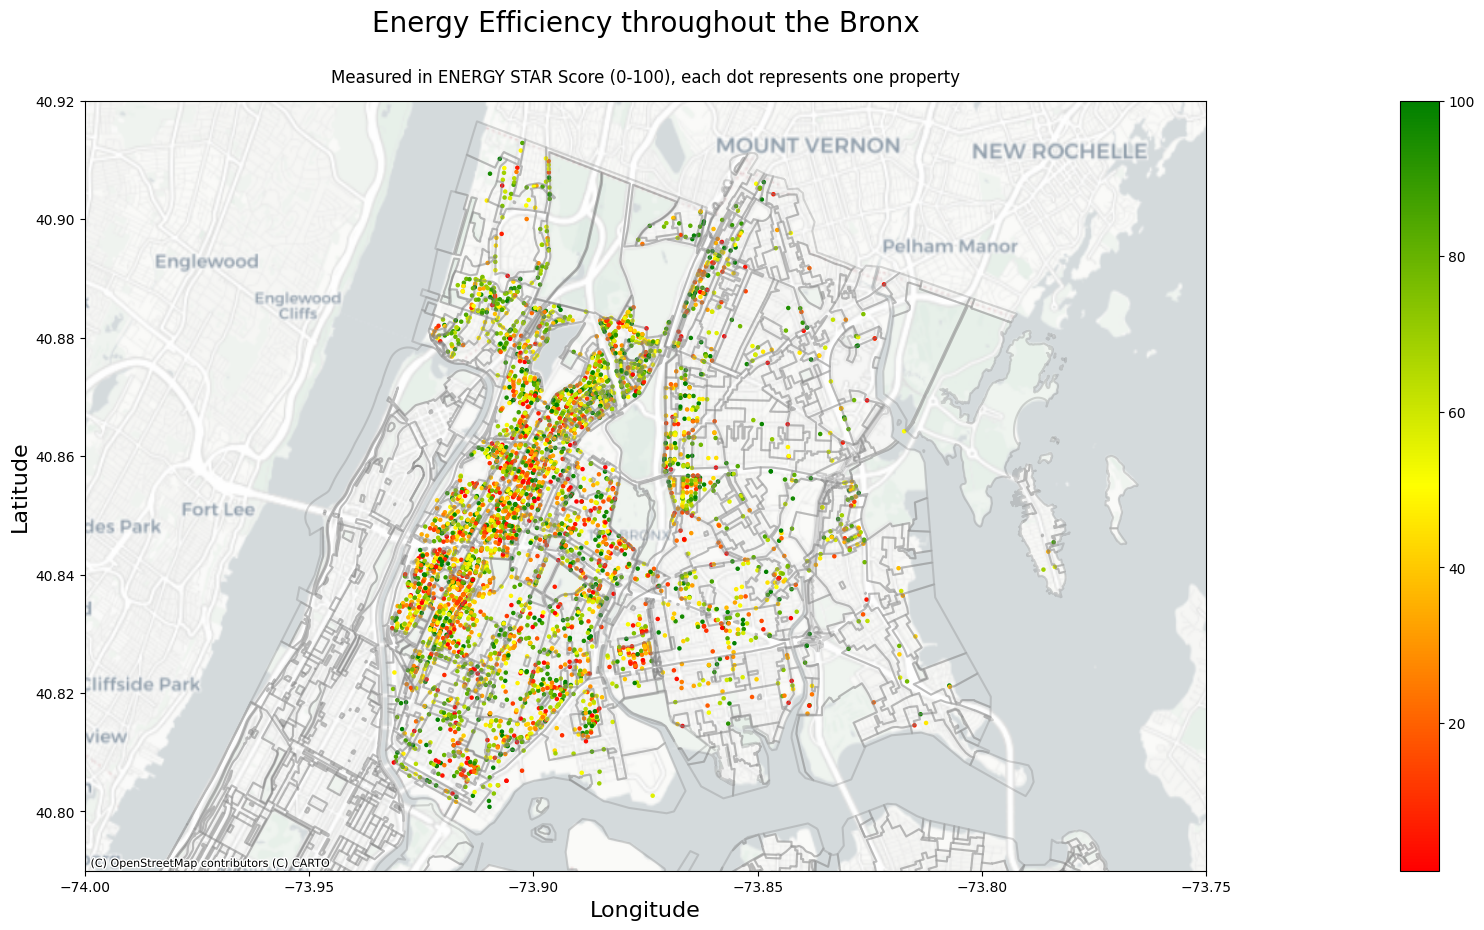

In [36]:
#set up geospatial choropleth color coding properties in borough by energy efficiency

borough_map = geopandas.GeoDataFrame(borough, geometry=geopandas.points_from_xy(borough.Longitude, borough.Latitude), crs="EPSG:4326")
borough_map = borough_map.dropna(subset=['Latitude', 'Longitude'])

gdf2 = geopandas.read_file('data/bronx.shp' ) #shapefile for borough with lowest avg score
gdflat2 = gdf2.to_crs({'init': 'epsg:4326'}) 
ax2 = gdflat2.boundary.plot(figsize=(50, 10), alpha=0.3, edgecolor='grey')

ax2.set_xlim([-74, -73.75]) 
ax2.set_ylim([40.79, 40.92]) 
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

ax2.set_title('Energy Efficiency throughout the Bronx', fontsize=20, pad=50) #title for borough with lowest avg score
ax2.set_xlabel('Longitude', fontsize=16) 
ax2.set_ylabel('Latitude', fontsize=16) 
plt.text(0.5, 1.03, 'Measured in ENERGY STAR Score (0-100), each dot represents one property', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12)

borough_map.plot(column='ENERGY STAR Score', cmap=custom, markersize=5, alpha=1.0, legend=True, ax=ax2)
plt.show()

<h3> Visualize energy efficiency compared to old home proportions across boroughs

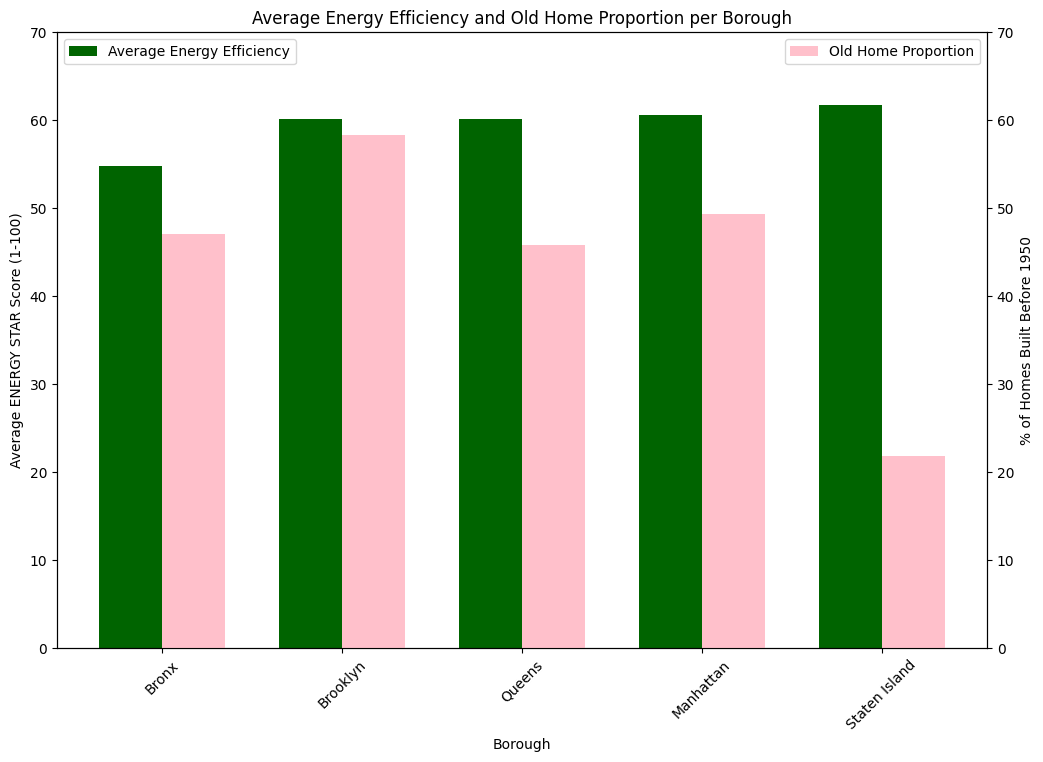

In [37]:
#set up bar plot with two axes

fig, ax1 = plt.subplots(figsize=(12, 8))
bar_width = 0.35
num_boroughs = len(properties_and_old_homes)
indices = np.arange(num_boroughs)

ax1.bar(indices, properties_and_old_homes['Average ENERGY STAR Score'], width=bar_width, label='Average Energy Efficiency', color='darkgreen')
ax1.set_ylim(0, 70)

ax2 = ax1.twinx()
ax2.bar(indices + bar_width, properties_and_old_homes['% of Homes Built Before 1950'], width=bar_width, color='pink', label='Old Home Proportion')
ax2.set_ylim(0, 70)

ax1.set_xticks(indices + bar_width / 2)
ax1.set_xticklabels(properties_and_old_homes['Borough'], rotation=45)

ax1.set_ylabel('Average ENERGY STAR Score (1-100)')
ax2.set_ylabel('% of Homes Built Before 1950')
ax1.set_xlabel('Borough')
ax1.set_title('Average Energy Efficiency and Old Home Proportion per Borough')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

<h3> Visualize energy efficiency compared to air pollutant concentrations across boroughs

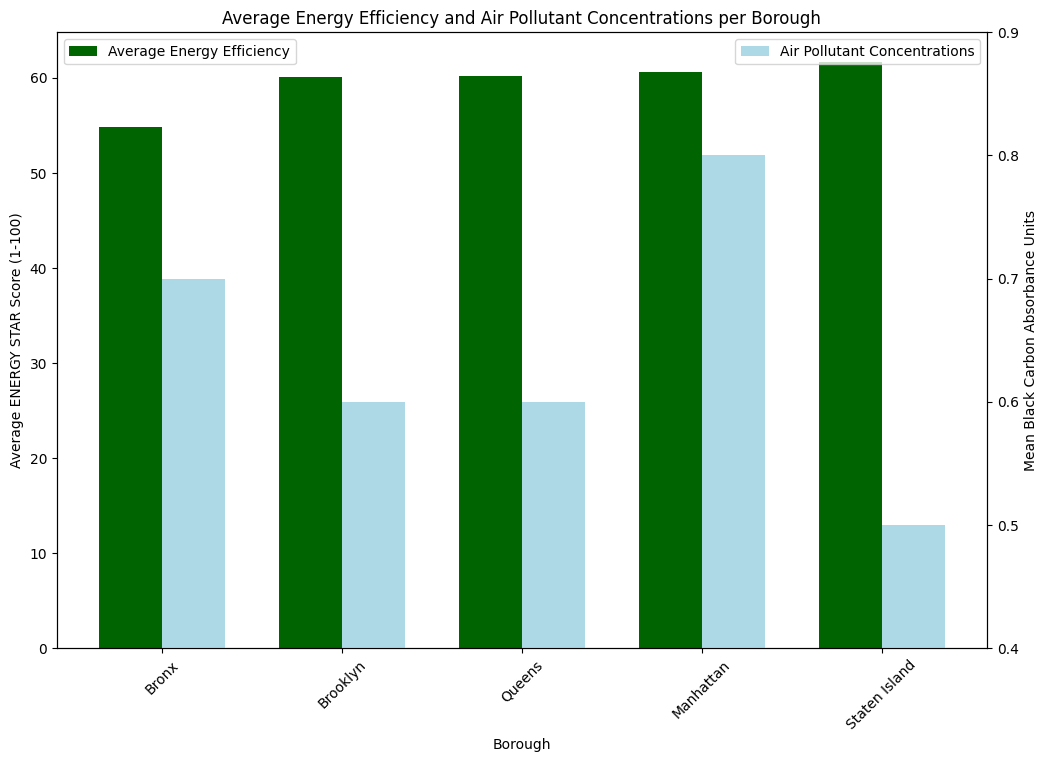

In [38]:
#set up bar plot with two axes (different scales)

fig, ax1 = plt.subplots(figsize=(12, 8))
bar_width = 0.35
num_boroughs = len(properties_and_black_carbon)
indices = np.arange(num_boroughs)

ax1.bar(indices, properties_and_black_carbon['Average ENERGY STAR Score'], width=bar_width, label='Average Energy Efficiency', color='darkgreen')

ax2 = ax1.twinx()
ax2.bar(indices + bar_width, properties_and_black_carbon['Mean Black Carbon Absorbance Units'], width=bar_width, color='lightblue', label='Air Pollutant Concentrations')
ax2.set_ylim(0.4, 0.9)

ax1.set_xticks(indices + bar_width / 2)
ax1.set_xticklabels(properties_and_black_carbon['Borough'], rotation=45)

ax1.set_ylabel('Average ENERGY STAR Score (1-100)')
ax2.set_ylabel('Mean Black Carbon Absorbance Units')
ax1.set_xlabel('Borough')
ax1.set_title('Average Energy Efficiency and Air Pollutant Concentrations per Borough')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

<h2> Part Five: Correlations

In [39]:
correlation1 = np.corrcoef(properties_and_old_homes['Average ENERGY STAR Score'], properties_and_old_homes['% of Homes Built Before 1950'])[0, 1]
correlation1

np.float64(-0.32618609713357055)

This correlation coefficient indicates a weak to moderate negative relationship between the average energy efficiency and proportion of older homes of/in a borough. Thus, as a borough's average energy efficiency increases, it will tend to contain a lower proportion of older homes.

In [40]:
correlation2 = np.corrcoef(properties_and_black_carbon['Average ENERGY STAR Score'], properties_and_black_carbon['Mean Black Carbon Absorbance Units'])[0, 1]
correlation2

np.float64(-0.38145051731919993)

This correlation coefficient indicates a weak to moderate negative relationship between the average energy efficiency and air pollutant concentration of/in a borough. Thus, as a borough's average energy efficiency increases, the air pollutant concentration will tend to be lower.